In [ ]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Literal, Tuple, List
from pydantic import BaseModel
import torch
import numpy as np
import requests
from huggingface_hub import hf_hub_download
import joblib
import torch.nn as nn



# Your DNN, scaler, model loader, and LSTM function definitions remain unchanged
# Assume `load_model()`, `triage_rules()`, `generate_reasoning()`, and `get_ollama_response()` are available

# Define the State
class TriageState(TypedDict):
    soldier_id: str
    vitals: dict
    injury: str
    classification: str
    rule_category: str
    rule_priority: str
    reasoning: str
    treatment: str

#define the model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

## Load the trained model from the hugging face model hub
def load_model():
    scaler_path = hf_hub_download(repo_id="Jeevan-1998/triage_model", filename="scaler.pkl")
    label_encoder_path = hf_hub_download(repo_id="Jeevan-1998/triage_model", filename="label_encoder.pkl")

    scaler = joblib.load(scaler_path)
    label_encoder = joblib.load(label_encoder_path)


    model_path = hf_hub_download(repo_id="Jeevan-1998/triage_model", filename="human_vital_sign_model.pth")

    # Load the model weights
    model = DNN(input_size=10, hidden_size=128, output_size=1)  # Adjust input_size if needed
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode
    
    
    return model, scaler, label_encoder

# ---- NODE: Classification Model Prediction ----
def node_classification_model(state: TriageState) -> TriageState:
    model, scaler, label_encoder = load_model()
    vitals = state['vitals']
    features = np.array([[vitals['heart_rate'][0], vitals['respiratory_rate'][0], vitals['body_temp'][0],
                          vitals['spo2'][0], vitals['sbp'][0], vitals['dbp'][0], vitals['age'][0],
                          vitals['gender'][0], vitals['weight'][0], vitals['height'][0]]])
    scaled = scaler.transform(features)
    tensor_input = torch.tensor(scaled, dtype=torch.float32)

    with torch.no_grad():
        output = model(tensor_input)
        prob = torch.sigmoid(output).numpy().flatten()[0]
        predicted = 1 if prob >= 0.5 else 0
        label = label_encoder.inverse_transform([predicted])[0]

    state["classification"] = f"{label} ({prob:.2f})"
    return state

# ----- Rule-based Triage Engine -----
def triage_rules(hr, sbp, dbp, spo2, rr):
    if sbp < 90 and hr > 130  :
        return "RED", "Immediate"
    elif spo2 < 92 or rr > 24:
        return "YELLOW", "Delayed"
    elif hr < 40 or spo2 < 80:
        return "BLACK", "Expectant"
    else:
        return "GREEN", "Minor"

# ---- NODE: Rule-Based Category ----
def node_rule_based_category(state: TriageState) -> TriageState:
    vitals = state['vitals']
    hr = vitals['heart_rate'][-1]
    sbp = vitals['sbp'][-1]
    dbp = vitals['dbp'][-1]
    spo2 = vitals['spo2'][-1]
    rr = vitals['respiratory_rate'][-1]

    cat, pri = triage_rules(hr, sbp, dbp, spo2, rr)
    state["rule_category"] = cat
    state["rule_priority"] = pri
    return state


def get_ollama_response(prompt: str, temperature=0.7, max_tokens=300,model_name ="llama3") -> str:
    ollama_url = "http://localhost:11434/v1/chat/completions"
    messages = [
        {"role": "system", "content": "You are a helpful battlefield medic assistant."},
        {"role": "user", "content": prompt}
    ]
    data = {
        "model": model_name,
        "messages": messages,
        "temperature": temperature,
        "max_tokens": max_tokens
    }

    response = requests.post(ollama_url, json=data)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return f"Error: {response.status_code}, {response.text}"



def generate_reasoning(injury, hr, sbp, spo2, rr, triage):
    ollama_url = "http://localhost:11434/v1/chat/completions"
    prompt = (
        f"A soldier has the following vital signs:\n"
        f"- Heart rate: {hr:.1f} bpm\n"
        f"- Systolic BP: {sbp:.1f} mmHg\n"
        f"- SpO2: {spo2:.1f}%\n"
        f"- Respiratory Rate: {rr:.1f} breaths/min\n"
        f"Injury: {injury}\n"
        f"Triage category: {triage}\n\n"
        f"Explain the reasoning behind this triage decision in a clinical tone."
    )
    messages=[
        {"role": "system", "content": "You are a medical triage assistant."},
        {"role": "user", "content": prompt}
    ]
    model_name = "llama3"
    data = {
        "model": model_name,
        "messages": messages,
    }
    response = requests.post(ollama_url, json=data)


    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return f"Error: {response.status_code}, {response.text}"


# ---- NODE: Reasoning Generation ----
def node_generate_reasoning(state: TriageState) -> TriageState:
    vitals = state['vitals']
    hr = vitals['heart_rate'][-1]
    sbp = vitals['sbp'][-1]
    spo2 = vitals['spo2'][-1]
    rr = vitals['respiratory_rate'][-1]
    injury = state["injury"]
    triage = f"{state['rule_category']} ({state['rule_priority']})"

    reason = generate_reasoning(injury, hr, sbp, spo2, rr, triage)
    state["reasoning"] = reason
    return state


# ---- NODE: Treatment Generation ----
def node_generate_treatment(state: TriageState) -> TriageState:
    vitals = state['vitals']
    injury = state["injury"]
    prompt = (
        f"Generate a battlefield treatment plan for:\n"
        f"Vitals: HR {vitals['heart_rate'][-1]}, BP {vitals['sbp'][-1]}/{vitals['dbp'][-1]}, "
        f"SpO2 {vitals['spo2'][-1]}%, RR {vitals['respiratory_rate'][-1]}\n"
        f"Injury: {injury}\n"
        f"Triage: {state['rule_category']} ({state['rule_priority']})\n"
        f"Provide a step-by-step plan considering battlefield constraints."
    )
    response = get_ollama_response(prompt)
    state["treatment"] = response
    return state


# ---- DEFINE GRAPH ----
graph_builder = StateGraph(TriageState)

graph_builder.add_node("classification_patient", node_classification_model)
graph_builder.add_node("rule_logic", node_rule_based_category)
graph_builder.add_node("generate_reasoning", node_generate_reasoning)
graph_builder.add_node("generate_treatment", node_generate_treatment)

# Define flow
graph_builder.add_edge(START, "classification_patient")
graph_builder.add_edge("classification_patient", "rule_logic")
graph_builder.add_edge("rule_logic", "generate_reasoning")
graph_builder.add_edge("generate_reasoning", "generate_treatment")
graph_builder.add_edge("generate_treatment", END)

triage_graph = graph_builder.compile()

# ---- SAMPLE EXECUTION ----
sample_state = {
    "soldier_id": "S01",
    "injury": "Gunshot wound to the chest With severe bleeding around the head",
    "vitals": {
        "heart_rate": [110, 120, 130],
        "respiratory_rate": [18, 22, 28],
        "body_temp": [37.0],
        "spo2": [95.0, 92.0, 88.0],
        "sbp": [110.0, 105.0, 90.0],
        "dbp": [70.0, 68.0, 60.0],
        "age": [30],
        "gender": [1],
        "weight": [70.0],
        "height": [175.0]
    },
    "classification": "",
    "rule_category": "",
    "rule_priority": "",
    "reasoning": "",
    "treatment": ""
}

result = triage_graph.invoke(sample_state)

import pprint
pprint.pprint(result)





A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\Program_files\Anaconda\envs\llamaIndex\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



{'classification': 'High Risk (0.00)',
 'injury': 'bGunshot wound to the chest',
 'reasoning': 'Based on the vital signs and injury presented, I would '
              'categorize this patient as Triage Category YELLOW, indicating '
              'delayed transfer or treatment.\n'
              '\n'
              "The patient's heart rate of 130 bpm is tachycardic but within "
              'an expected range for someone who has just been wounded. '
              'However, their systolic blood pressure of 90 mmHg is '
              'significantly low, indicating hypotension that may compromise '
              'their cardiovascular function and overall perfusion. This is a '
              'concerning finding, especially in the context of a gunshot '
              'wound to the chest.\n'
              '\n'
              "The patient's oxygen saturation of 88% is below normal range, "
              'suggesting possible respiratory or cardiac insufficiency. A '
              'respiratory ra

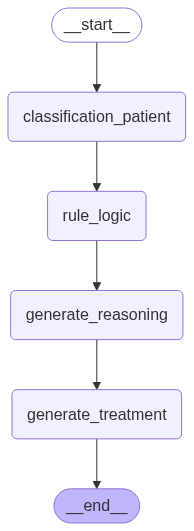

In [2]:
from IPython.display import display, Image 

display(Image(triage_graph.get_graph(xray=True).draw_mermaid_png()))